In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the CIFAR-10 dataset
(train_data, test_data), info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)

# Normalize the images to the range [0, 1]
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_data = train_data.map(normalize_img).batch(128).shuffle(10000)
test_data = test_data.map(normalize_img).batch(128)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.CIJF88_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.CIJF88_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
from tensorflow.keras import layers

class PrimaryCapsule(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(PrimaryCapsule, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.conv = layers.Conv2D(filters=self.num_capsules * self.dim_capsules,
                                  kernel_size=9,
                                  strides=2,
                                  padding='valid')

    def call(self, inputs):
        x = self.conv(inputs)
        x = tf.reshape(x, (-1, x.shape[1] * x.shape[2] * self.num_capsules, self.dim_capsules))
        return self.squash(x)

    def squash(self, vectors):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * vectors / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())


In [6]:
class DigitCapsule(layers.Layer):
    def __init__(self, num_capsules, dim_capsules, num_routing=3, **kwargs):
        super(DigitCapsule, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.num_routing = num_routing

    def build(self, input_shape):
        self.W = self.add_weight(shape=[self.num_capsules, input_shape[1], self.dim_capsules, input_shape[2]],
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, 1)
        inputs_tiled = tf.tile(inputs_expand, [1, self.num_capsules, 1, 1])
        inputs_tiled = tf.expand_dims(inputs_tiled, -1)  # Add an extra dimension for correct matmul
        inputs_hat = tf.squeeze(tf.matmul(self.W, inputs_tiled), axis=-1)

        b = tf.zeros(shape=[tf.shape(inputs_hat)[0], self.num_capsules, inputs_hat.shape[2], 1])

        for i in range(self.num_routing):
            c = tf.nn.softmax(b, axis=1)
            s = tf.reduce_sum(c * inputs_hat, axis=2)
            v = self.squash(s)
            if i < self.num_routing - 1:
                a = tf.reduce_sum(inputs_hat * tf.expand_dims(v, 2), axis=-1, keepdims=True)
                b += a

        return v

    def squash(self, vectors):
        s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm)
        return scale * vectors / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())


In [7]:
def build_capsnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu')(inputs)

    # Primary capsule layer
    primary_caps = PrimaryCapsule(num_capsules=8, dim_capsules=32)(conv1)

    # Digit capsule layer
    digit_caps = DigitCapsule(num_capsules=num_classes, dim_capsules=16)(primary_caps)

    # Length layer (squash to get class probabilities)
    outputs = layers.Lambda(lambda z: tf.sqrt(tf.reduce_sum(tf.square(z), axis=-1)))(digit_caps)

    return tf.keras.Model(inputs, outputs)


In [8]:
# Build and compile the model
input_shape = (32, 32, 3)
num_classes = 10
model = build_capsnet(input_shape, num_classes)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=10, validation_data=test_data)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 87s 169ms/step - accuracy: 0.1090 - loss: 2.2872 - val_accuracy: 0.1934 - val_loss: 2.1148
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 106s 124ms/step - accuracy: 0.2310 - loss: 2.0659 - val_accuracy: 0.3804 - val_loss: 1.7987
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.3856 - loss: 1.7668 - val_accuracy: 0.4237 - val_loss: 1.6524
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 122ms/step - accuracy: 0.4440 - loss: 1.6159 - val_accuracy: 0.4471 - val_loss: 1.5919
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.4710 - loss: 1.5316 - val_accuracy: 0.4868 - val_loss: 1.4906
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 123ms/step - accuracy: 0.4998 - loss: 1.4600 - val_accuracy: 0.5084 - val_loss: 1.4261
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.5241 - loss: 1.3977 - val_accuracy: 0.5200 - val_loss: 1.4012
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.5436 - loss: 

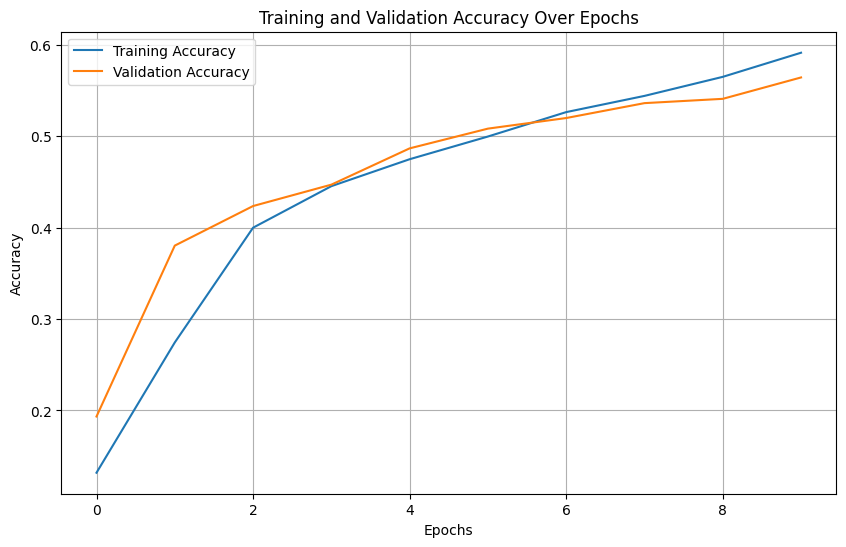

In [9]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


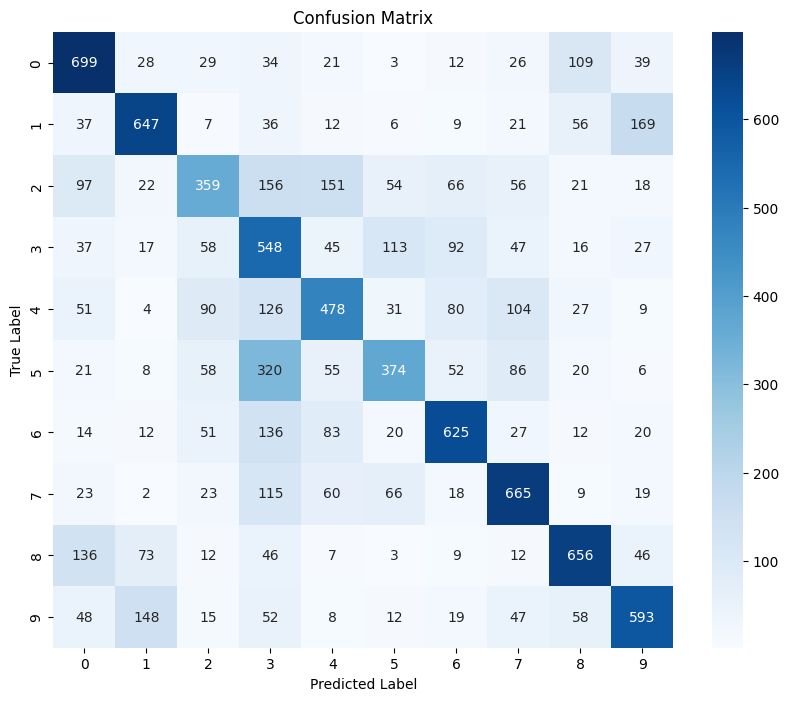

In [10]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and ground truth labels
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
